In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
import time

def distance_to_motorway_and_trunk(lat, lon, search_radius_km=5):
    print(f"위도 {lat}, 경도 {lon} 주변 도로 분석")
    
    try:
        # 도로 네트워크 가져오기
        G = ox.graph_from_point((lat, lon), dist=search_radius_km * 1000, network_type="drive", simplify=True)
    except Exception as e:
        print(f"네트워크 가져오기 실패: {e}")
        return None, None

    print("노드를 찾는 중...")
    try:
        orig_node = ox.nearest_nodes(G, lon, lat)
    except Exception as e:
        print(f"가장 가까운 노드 찾기 실패: {e}")
        return None, None

    # 고속도로와 국도 엣지 필터링
    print("고속도로와 국도를 필터링하는 중...")
    motorway_edges = []
    trunk_edges = []
    for u, v, data in G.edges(data=True):
        highway = data.get('highway')
        if highway is None:
            continue
        if isinstance(highway, list):
            if 'motorway' in highway:
                motorway_edges.append((u, v))
            if 'trunk' in highway:
                trunk_edges.append((u, v))
        elif isinstance(highway, str):
            if highway == 'motorway':
                motorway_edges.append((u, v))
            elif highway == 'trunk':
                trunk_edges.append((u, v))

    print(f"고속도로: {len(motorway_edges)}개, 국도: {len(trunk_edges)}개 세그먼트를 찾았습니다.")

    # 고속도로까지의 경로 거리 구하기
    min_motorway_km = None
    if motorway_edges:
        motorway_nodes = set()
        for u, v in motorway_edges:
            motorway_nodes.add(u)
            motorway_nodes.add(v)
        motorway_distances = []
        for target_node in motorway_nodes:
            try:
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                route_length = sum(
                    min(data['length'] for _, data in G.get_edge_data(u, v).items())
                    for u, v in zip(route[:-1], route[1:])
                )
                motorway_distances.append(route_length)
            except nx.NetworkXNoPath:
                continue
        if motorway_distances:
            min_motorway_km = min(motorway_distances) / 1000
            print(f"가장 가까운 고속도로까지의 경로 거리: {min_motorway_km:.2f} km")
        else:
            print("고속도로까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 고속도로가 없습니다.")

    # 국도까지의 경로 거리 구하기
    min_trunk_km = None
    if trunk_edges:
        trunk_nodes = set()
        for u, v in trunk_edges:
            trunk_nodes.add(u)
            trunk_nodes.add(v)
        trunk_distances = []
        for target_node in trunk_nodes:
            try:
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                route_length = sum(
                    min(data['length'] for _, data in G.get_edge_data(u, v).items())
                    for u, v in zip(route[:-1], route[1:])
                )
                trunk_distances.append(route_length)
            except nx.NetworkXNoPath:
                continue
        if trunk_distances:
            min_trunk_km = min(trunk_distances) / 1000
            print(f"가장 가까운 국도까지의 경로 거리: {min_trunk_km:.2f} km")
        else:
            print("국도까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 국도가 없습니다.")

    return min_motorway_km, min_trunk_km

# 데이터 로드
df = pd.read_csv('/Users/besuperst/Library/Mobile Documents/com~apple~CloudDocs/DEV/DataDev/ML_KIC/지산데이터전처리/KIC/KIC_Cord.csv')

motorway_distances = []
trunk_distances = []

for i in range(len(df)):
    center_name = df.iloc[i, 0]  # 센터 이름
    lat = df.iloc[i, 1]
    lon = df.iloc[i, 2]
    print(f"\n{i + 1}/{len(df)}: 센터명 {center_name}, 위도 {lat}, 경도 {lon} 처리 중...")
    motorway_km, trunk_km = distance_to_motorway_and_trunk(lat, lon, search_radius_km=5)
    motorway_distances.append(motorway_km if motorway_km is not None else 0)
    trunk_distances.append(trunk_km if trunk_km is not None else 0)
    time.sleep(1)  # 요청 간 1초 대기

# 결과 저장
df_result = pd.DataFrame({
    '센터명': df.iloc[:, 0],  # 센터 이름
    '가장 가까운 국도까지 거리(km)': trunk_distances,
    '가장 가까운 고속도로까지 거리(km)': motorway_distances
})

df_result.to_csv('KIC_Road.csv', index=False, encoding='utf-8-sig')
print("결과가 csv에 저장되었습니다.")


1/1428: 센터명 강릉 공공임대형 지식산업센터, 위도 37.806206864259, 경도 128.854086356953 처리 중...
위도 37.806206864259, 경도 128.854086356953 주변 도로 분석
노드를 찾는 중...
고속도로와 국도를 필터링하는 중...
고속도로: 7개, 국도: 73개 세그먼트를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 7.81 km
가장 가까운 국도까지의 경로 거리: 0.91 km

2/1428: 센터명 동해지식산업센터, 위도 37.4815755496578, 경도 129.133811284715 처리 중...
위도 37.4815755496578, 경도 129.133811284715 주변 도로 분석
노드를 찾는 중...
고속도로와 국도를 필터링하는 중...
고속도로: 6개, 국도: 4개 세그먼트를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 6.42 km
가장 가까운 국도까지의 경로 거리: 3.65 km

3/1428: 센터명 표준공장1동, 위도 37.4808418834247, 경도 129.153095048545 처리 중...
위도 37.4808418834247, 경도 129.153095048545 주변 도로 분석
노드를 찾는 중...
고속도로와 국도를 필터링하는 중...
고속도로: 2개, 국도: 2개 세그먼트를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 9.70 km
가장 가까운 국도까지의 경로 거리: 5.65 km

4/1428: 센터명 표준공장2동, 위도 37.4808418834247, 경도 129.153095048545 처리 중...
위도 37.4808418834247, 경도 129.153095048545 주변 도로 분석
노드를 찾는 중...
고속도로와 국도를 필터링하는 중...
고속도로: 2개, 국도: 2개 세그먼트를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 9.70 km
가장 가까운 국도까지의 경로 거리: 5.65 km

5/1428: 센터명 표준공장3동, 위도 37

#2 경로 거리

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import pandas as pd

def distance_to_motorway_and_trunk(lat, lon, search_radius_km=5):
    print(f"위도 {lat}, 경도 {lon} 주변 {search_radius_km}km 반경의 도로 네트워크를 분석합니다.")
    
    G = ox.graph_from_point((lat, lon),
                           dist=search_radius_km * 1000,
                           network_type="drive",
                           simplify=True)

    print("네트워크에서 가장 가까운 노드를 찾는 중...")
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """두 지점 간의 하버사인 거리(미터)를 계산합니다."""
        from math import radians, sin, cos, sqrt, atan2
        
        R = 6371000  # 지구 반경(미터)
        
        # 라디안으로 변환
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        # 위도, 경도 차이
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        # 하버사인 공식
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        distance = R * c
        
        return distance
    
    # 모든 노드에 대해 거리 계산하여 가장 가까운 노드 찾기
    min_dist = float('inf')
    orig_node = None
    
    for node, data in G.nodes(data=True):
        node_lat = data.get('y')
        node_lon = data.get('x')
        if node_lat is not None and node_lon is not None:
            dist = haversine_distance(lat, lon, node_lat, node_lon)
            if dist < min_dist:
                min_dist = dist
                orig_node = node
    
    if orig_node is None:
        print("오류: 네트워크에서 노드를 찾을 수 없습니다.")
        return None, None
    
    print(f"시작 노드를 찾았습니다: {orig_node}")
    
    # 고속도로와 국도 엣지 필터링
    print("고속도로와 국도를 필터링하는 중...")
    
    motorway_edges = []
    trunk_edges = []
    
    for u, v, data in G.edges(data=True):
        highway = data.get('highway')
        if highway is None:
            continue
            
        # 리스트인 경우 처리
        if isinstance(highway, list):
            if 'motorway' in highway:
                motorway_edges.append((u, v))
            if 'trunk' in highway:
                trunk_edges.append((u, v))
        # 문자열인 경우 처리
        elif isinstance(highway, str):
            if highway == 'motorway':
                motorway_edges.append((u, v))
            elif highway == 'trunk':
                trunk_edges.append((u, v))
    
    print(f"고속도로: {len(motorway_edges)}개, 국도: {len(trunk_edges)}개 세그먼트를 찾았습니다.")
    
    # 결과 저장 변수
    min_motorway_km = None
    min_trunk_km = None
    
    # 고속도로까지의 경로 거리 구하기
    if motorway_edges:
        # 고속도로 엣지의 모든 노드 가져오기
        motorway_nodes = set()
        for u, v in motorway_edges:
            motorway_nodes.add(u)
            motorway_nodes.add(v)
        
        print(f"고속도로 노드: {len(motorway_nodes)}개를 찾았습니다.")
        
        motorway_distances = []
        for target_node in motorway_nodes:
            try:
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                route_length = 0
                for i in range(len(route)-1):
                    u, v = route[i], route[i+1]
                    if G.has_edge(u, v):
                        # 두 노드 사이의 모든 가능한 엣지 중 최소 거리 찾기
                        edge_data = G.get_edge_data(u, v)
                        min_length = float('inf')
                        for _, data in edge_data.items():
                            if 'length' in data and data['length'] < min_length:
                                min_length = data['length']
                        
                        if min_length != float('inf'):
                            route_length += min_length
                
                motorway_distances.append(route_length)
            except nx.NetworkXNoPath:
                continue
        
        # 가장 짧은 경로 거리 찾기 (미터에서 킬로미터로 변환)
        if motorway_distances:
            min_motorway_km = min(motorway_distances) / 1000
            print(f"가장 가까운 고속도로까지의 경로 거리: {min_motorway_km:.2f} km")
        else:
            print("고속도로까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 고속도로가 없습니다.")
        
    # 국도까지의 경로 거리 구하기
    if trunk_edges:
        # 국도 엣지의 모든 노드 가져오기
        trunk_nodes = set()
        for u, v in trunk_edges:
            trunk_nodes.add(u)
            trunk_nodes.add(v)
        
        print(f"국도 노드: {len(trunk_nodes)}개를 찾았습니다.")
        
        # 각 국도 노드까지의 최단 경로 찾기
        trunk_distances = []
        for target_node in trunk_nodes:
            try:
                # 최단 경로 찾기
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                
                # 경로 길이 계산 (직접 계산)
                route_length = 0
                for i in range(len(route)-1):
                    u, v = route[i], route[i+1]
                    if G.has_edge(u, v):
                        # 두 노드 사이의 모든 가능한 엣지 중 최소 거리 찾기
                        edge_data = G.get_edge_data(u, v)
                        min_length = float('inf')
                        for _, data in edge_data.items():
                            if 'length' in data and data['length'] < min_length:
                                min_length = data['length']
                        
                        if min_length != float('inf'):
                            route_length += min_length
                
                trunk_distances.append(route_length)
            except nx.NetworkXNoPath:
                # 경로가 없는 경우 무시
                continue
        
        if trunk_distances:
            min_trunk_km = min(trunk_distances) / 1000
            print(f"가장 가까운 국도까지의 경로 거리: {min_trunk_km:.2f} km")
        else:
            print("국도까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 국도가 없습니다.")
    
    return min_motorway_km, min_trunk_km

df = pd.read_csv('../KIC/KIC_Cord.csv')

motorway_distances = []
trunk_distances = []

for i in range(len(df)):
    lat = df.iloc[i, 1]
    lon = df.iloc[i, 2]
    motorway_km, trunk_km = distance_to_motorway_and_trunk(lat, lon, search_radius_km=5)


df['가장 가까운 국도까지 거리(km)'] = trunk_distances
df['가장 가까운 고속도로까지 거리(km)'] = motorway_distances

df.to_csv('KIC_Final.csv', index=False, encoding='utf-8-sig')

위도 37.806206864259, 경도 128.854086356953 주변 5km 반경의 도로 네트워크를 분석합니다.
네트워크에서 가장 가까운 노드를 찾는 중...
시작 노드를 찾았습니다: 3622672265
고속도로와 국도를 필터링하는 중...
고속도로: 7개, 국도: 73개 세그먼트를 찾았습니다.
고속도로 노드: 10개를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 7.81 km
국도 노드: 73개를 찾았습니다.
가장 가까운 국도까지의 경로 거리: 0.91 km
위도 37.4815755496578, 경도 129.133811284715 주변 5km 반경의 도로 네트워크를 분석합니다.
네트워크에서 가장 가까운 노드를 찾는 중...
시작 노드를 찾았습니다: 529257597
고속도로와 국도를 필터링하는 중...
고속도로: 6개, 국도: 4개 세그먼트를 찾았습니다.
고속도로 노드: 8개를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 6.42 km
국도 노드: 5개를 찾았습니다.
가장 가까운 국도까지의 경로 거리: 3.65 km
위도 37.4808418834247, 경도 129.153095048545 주변 5km 반경의 도로 네트워크를 분석합니다.
네트워크에서 가장 가까운 노드를 찾는 중...
시작 노드를 찾았습니다: 5566125951
고속도로와 국도를 필터링하는 중...
고속도로: 2개, 국도: 2개 세그먼트를 찾았습니다.
고속도로 노드: 4개를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 9.70 km
국도 노드: 4개를 찾았습니다.
가장 가까운 국도까지의 경로 거리: 5.65 km
위도 37.4808418834247, 경도 129.153095048545 주변 5km 반경의 도로 네트워크를 분석합니다.
네트워크에서 가장 가까운 노드를 찾는 중...
시작 노드를 찾았습니다: 5566125951
고속도로와 국도를 필터링하는 중...
고속도로: 2개, 국도: 2개 세그먼트를 찾았습니다.
고속도로 노드: 4개를 찾았습니다.
가장 가까운 고속도로

KeyboardInterrupt: 

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np

def distance_to_motorway_and_trunk(lat, lon, search_radius_km=5):
    print(f"위도 {lat}, 경도 {lon} 주변 {search_radius_km}km 반경의 도로 네트워크를 분석합니다.")
    
    # 1. 도로 네트워크 불러오기
    G = ox.graph_from_point((lat, lon),
                            dist=search_radius_km * 1000,
                            network_type="drive",
                            simplify=True)

    print("네트워크에서 가장 가까운 노드를 찾는 중...")

    def haversine_distance(lat1, lon1, lat2, lon2):
        from math import radians, sin, cos, sqrt, atan2
        R = 6371000  # 지구 반경(미터)
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    # 2. 입력 좌표에서 가장 가까운 노드 찾기
    min_dist = float('inf')
    orig_node = None
    for node, data in G.nodes(data=True):
        node_lat = data.get('y')
        node_lon = data.get('x')
        if node_lat is not None and node_lon is not None:
            dist = haversine_distance(lat, lon, node_lat, node_lon)
            if dist < min_dist:
                min_dist = dist
                orig_node = node

    if orig_node is None:
        print("오류: 네트워크에서 노드를 찾을 수 없습니다.")
        return None, None

    print(f"시작 노드를 찾았습니다: {orig_node}")

    # 3. 고속도로와 국도 엣지 필터링
    print("고속도로와 국도를 필터링하는 중...")
    motorway_edges = []
    trunk_edges = []
    for u, v, data in G.edges(data=True):
        highway = data.get('highway')
        if highway is None:
            continue
        if isinstance(highway, list):
            if 'motorway' in highway:
                motorway_edges.append((u, v))
            if 'trunk' in highway:
                trunk_edges.append((u, v))
        elif isinstance(highway, str):
            if highway == 'motorway':
                motorway_edges.append((u, v))
            elif highway == 'trunk':
                trunk_edges.append((u, v))

    print(f"고속도로: {len(motorway_edges)}개, 국도: {len(trunk_edges)}개 세그먼트를 찾았습니다.")

    # 4. 고속도로까지의 경로 거리 구하기
    min_motorway_km = None
    if motorway_edges:
        motorway_nodes = set()
        for u, v in motorway_edges:
            motorway_nodes.add(u)
            motorway_nodes.add(v)
        print(f"고속도로 노드: {len(motorway_nodes)}개를 찾았습니다.")
        motorway_distances = []
        for target_node in motorway_nodes:
            try:
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                route_length = 0
                for i in range(len(route)-1):
                    u, v = route[i], route[i+1]
                    if G.has_edge(u, v):
                        edge_data = G.get_edge_data(u, v)
                        min_length = float('inf')
                        for _, data in edge_data.items():
                            if 'length' in data and data['length'] < min_length:
                                min_length = data['length']
                        if min_length != float('inf'):
                            route_length += min_length
                motorway_distances.append(route_length)
            except nx.NetworkXNoPath:
                continue
        if motorway_distances:
            min_motorway_km = min(motorway_distances) / 1000
            print(f"가장 가까운 고속도로까지의 경로 거리: {min_motorway_km:.2f} km")
        else:
            print("고속도로까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 고속도로가 없습니다.")

    # 5. 국도까지의 경로 거리 구하기
    min_trunk_km = None
    if trunk_edges:
        trunk_nodes = set()
        for u, v in trunk_edges:
            trunk_nodes.add(u)
            trunk_nodes.add(v)
        print(f"국도 노드: {len(trunk_nodes)}개를 찾았습니다.")
        trunk_distances = []
        for target_node in trunk_nodes:
            try:
                route = nx.shortest_path(G, orig_node, target_node, weight='length')
                route_length = 0
                for i in range(len(route)-1):
                    u, v = route[i], route[i+1]
                    if G.has_edge(u, v):
                        edge_data = G.get_edge_data(u, v)
                        min_length = float('inf')
                        for _, data in edge_data.items():
                            if 'length' in data and data['length'] < min_length:
                                min_length = data['length']
                        if min_length != float('inf'):
                            route_length += min_length
                trunk_distances.append(route_length)
            except nx.NetworkXNoPath:
                continue
        if trunk_distances:
            min_trunk_km = min(trunk_distances) / 1000
            print(f"가장 가까운 국도까지의 경로 거리: {min_trunk_km:.2f} km")
        else:
            print("국도까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 국도가 없습니다.")

    return min_motorway_km, min_trunk_km

# 위도, 경도 입력
lat = 37.806206864259
lon = 128.854086356953

motorway_km, trunk_km = distance_to_motorway_and_trunk(lat, lon, search_radius_km=5)

print(f"\n최종 결과:")
print(f"가장 가까운 고속도로까지의 경로 거리: {motorway_km} km")
print(f"가장 가까운 국도까지의 경로 거리: {trunk_km} km")

위도 37.806206864259, 경도 128.854086356953 주변 5km 반경의 도로 네트워크를 분석합니다.
네트워크에서 가장 가까운 노드를 찾는 중...
시작 노드를 찾았습니다: 3622672265
고속도로와 국도를 필터링하는 중...
고속도로: 7개, 국도: 73개 세그먼트를 찾았습니다.
고속도로 노드: 10개를 찾았습니다.
가장 가까운 고속도로까지의 경로 거리: 7.81 km
국도 노드: 73개를 찾았습니다.
가장 가까운 국도까지의 경로 거리: 0.91 km

최종 결과:
가장 가까운 고속도로까지의 경로 거리: 7.811487913703444 km
가장 가까운 국도까지의 경로 거리: 0.9056853259826974 km


가장 가까운 고속도로까지의 경로 거리: 7.81 km
가장 가까운 국도까지의 경로 거리: 0.91 km


findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Font family 'Gmarket Sans TTF' not found.
findfont: Fo

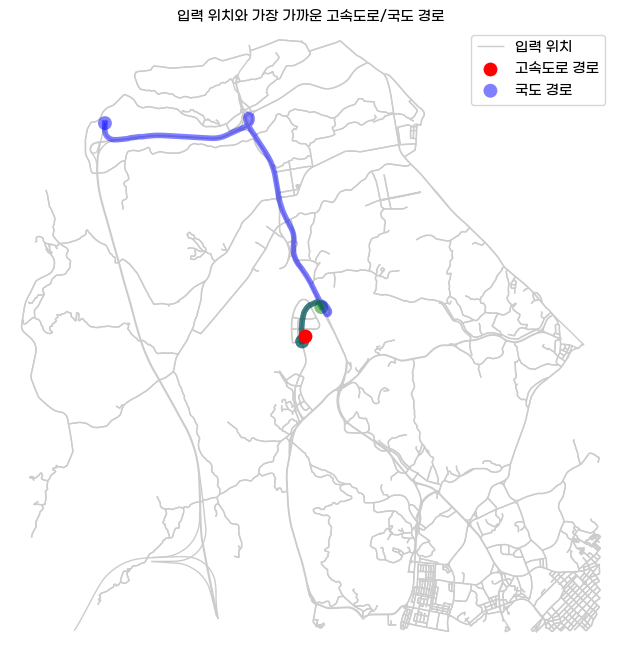

In [6]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



# 한글 폰트 직접 지정 (GmarketSansTTFMedium.ttf 경로 사용)
font_path = "/Users/besuperst/Library/Mobile Documents/com~apple~CloudDocs/DEV/DataDev/ML_DEV_Center/GmarketSansTTFMedium.ttf"  # 절대경로 또는 상대경로로 지정
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())
plt.rcParams['axes.unicode_minus'] = False

def distance_and_plot(lat, lon, search_radius_km=5):
    G = ox.graph_from_point((lat, lon),
                            dist=search_radius_km * 1000,
                            network_type="drive",
                            simplify=True)

    # 입력 좌표에서 가장 가까운 노드 찾기
    orig_node = ox.nearest_nodes(G, lon, lat)

    # 고속도로/국도 엣지 필터링
    motorway_edges = []
    trunk_edges = []
    for u, v, data in G.edges(data=True):
        highway = data.get('highway')
        if highway is None:
            continue
        if isinstance(highway, list):
            if 'motorway' in highway:
                motorway_edges.append((u, v))
            if 'trunk' in highway:
                trunk_edges.append((u, v))
        elif isinstance(highway, str):
            if highway == 'motorway':
                motorway_edges.append((u, v))
            elif highway == 'trunk':
                trunk_edges.append((u, v))

    # 고속도로/국도 노드 집합
    motorway_nodes = set()
    for u, v in motorway_edges:
        motorway_nodes.add(u)
        motorway_nodes.add(v)
    trunk_nodes = set()
    for u, v in trunk_edges:
        trunk_nodes.add(u)
        trunk_nodes.add(v)

    # 가장 가까운 고속도로 노드 및 경로
    motorway_route = None
    if motorway_nodes:
        lengths = {}
        for node in motorway_nodes:
            try:
                path = nx.shortest_path(G, orig_node, node, weight='length')
                length = nx.path_weight(G, path, weight='length')
                lengths[node] = (length, path)
            except nx.NetworkXNoPath:
                continue
        if lengths:
            min_node = min(lengths, key=lambda k: lengths[k][0])
            motorway_route = lengths[min_node][1]
            print(f"가장 가까운 고속도로까지의 경로 거리: {lengths[min_node][0]/1000:.2f} km")
        else:
            print("고속도로까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 고속도로가 없습니다.")

    # 가장 가까운 국도 노드 및 경로
    trunk_route = None
    if trunk_nodes:
        lengths = {}
        for node in trunk_nodes:
            try:
                path = nx.shortest_path(G, orig_node, node, weight='length')
                length = nx.path_weight(G, path, weight='length')
                lengths[node] = (length, path)
            except nx.NetworkXNoPath:
                continue
        if lengths:
            min_node = min(lengths, key=lambda k: lengths[k][0])
            trunk_route = lengths[min_node][1]
            print(f"가장 가까운 국도까지의 경로 거리: {lengths[min_node][0]/1000:.2f} km")
        else:
            print("국도까지의 경로를 찾을 수 없습니다.")
    else:
        print("검색 반경 내에 국도가 없습니다.")

    # 지도 시각화
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='white', node_size=0, edge_color='#cccccc')
    # 입력 위치
    ax.scatter(lon, lat, c='red', s=80, label='입력 위치', zorder=5)
    # 고속도로 경로
    if motorway_route:
        ox.plot_graph_route(G, motorway_route, route_color='blue', route_linewidth=4, ax=ax, show=False, close=False, orig_dest_node_color='blue')
    # 국도 경로
    if trunk_route:
        ox.plot_graph_route(G, trunk_route, route_color='green', route_linewidth=4, ax=ax, show=False, close=False, orig_dest_node_color='green')
    ax.legend(['입력 위치', '고속도로 경로', '국도 경로'], prop=fontprop)
    plt.title('입력 위치와 가장 가까운 고속도로/국도 경로', fontproperties=fontprop)
    plt.show()

# 사용 예시
lat = 37.806206864259
lon = 128.854086356953
distance_and_plot(lat, lon, search_radius_km=5)